In [1]:
import zipfile
import json
import pandas as pd


# Chat Data Analysis Notebook

This Jupyter notebook aims to analyze chat data between users and an AI assistant. The data consists of multiple conversations each containing various messages from both the user and the assistant. The key objectives of this analysis are to understand sentiment trends in the messages, identify the busiest times for user interaction, analyze assistant response times, and study the distribution of user feedback ratings.


## Data Extraction and Preprocessing

The chat data is stored in a zip file which contains JSON files. The first step involves extracting the zip file and loading the JSON data into a Python dictionary. This raw data is then preprocessed by flattening each conversation and extracting relevant information such as the user's messages, the assistant's responses, and the timestamps. The preprocessed data is then converted into a pandas DataFrame for further analysis.


In [ ]:
# Path to the zip file
zip_file_path = '.<file_name>.zip'

# Path to extract the zip file
extract_path = '../chat_data'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)



In [11]:
dir_name = 'chatgpt_062025'
file_path = f'./{dir_name}/conversations.json'
# Load the JSON file
with open(file_path, 'r') as f:
    data = json.load(f)


In [6]:
# Further modified function to flatten the conversation and extract the necessary information
def flatten_conversation(conversation):
    flattened_convo = []
    mapping = conversation["mapping"]
    
    # Loop through each message in the mapping
    for message_id, message_data in mapping.items():
        # Check if the message has a message field
        if "message" in message_data and message_data["message"] is not None:
            # Check if the message is by the user and has a response from the assistant
            if message_data["message"]["author"]["role"] == "user" and message_data["children"]:
                # Get the assistant's response
                assistant_response_id = message_data["children"][0] if message_data["children"][0] in mapping else None
                if assistant_response_id and mapping[assistant_response_id]["message"] and "parts" in mapping[assistant_response_id]["message"]["content"]:
                    if isinstance(mapping[assistant_response_id]["message"]["content"]["parts"], list) and len(mapping[assistant_response_id]["message"]["content"]["parts"]) > 0 and isinstance(mapping[assistant_response_id]["message"]["content"]["parts"][0], str):
                        assistant_response = mapping[assistant_response_id]["message"]["content"]["parts"][0]
                    else:
                        assistant_response = None
                else:
                    assistant_response = None
                # Add the user's message, the assistant's response, and the metadata to the list
                if "parts" in message_data["message"]["content"]:
                    if isinstance(message_data["message"]["content"]["parts"], list) and len(message_data["message"]["content"]["parts"]) > 0 and isinstance(message_data["message"]["content"]["parts"][0], str):
                        user_message = message_data["message"]["content"]["parts"][0]
                    else:
                        user_message = None
                else:
                    user_message = None
                flattened_convo.append({
                    "conversation_id": conversation["id"],
                    "conversation_title": conversation["title"],
                    "user_message_id": message_id,
                    "user_message": user_message,
                    "assistant_message_id": assistant_response_id,
                    "assistant_message": assistant_response,
                    "user_message_timestamp": message_data["message"]["create_time"],
                    "assistant_message_timestamp": mapping[assistant_response_id]["message"]["create_time"] if assistant_response_id else None,
                })
            
    return flattened_convo

# Flatten each conversation and create a DataFrame
flattened_conversations = [flatten_conversation(conversation) for conversation in data]
flattened_conversations = [item for sublist in flattened_conversations for item in sublist] # Flatten the list
conversations_df = pd.DataFrame(flattened_conversations)


# reverse the order of the rows
conversations_df = conversations_df.iloc[::-1]

# Print the first few rows of the DataFrame
conversations_df.head()


,conversation_id,conversation_title,user_message_id,user_message,assistant_message_id,assistant_message,user_message_timestamp,assistant_message_timestamp
5718,67527d91-b214-8008-84f6-1347e4c5dba8,Voting Power in LLC,bbb21519-fd91-4a15-bd2c-8ac6f56587c1,How do you determine voting power for purposes...,8c7c6554-e2aa-4984-b79e-ff1c4d616b8b,**Clarifying voting power**\n\nI'm working thr...,1.733459e+09,1.733459e+09
5717,6752d131-e138-8008-a86a-8d1bb977ac76,Next Steps After Attention,bbb21822-308e-41ed-a665-030755e051a8,"In the AI space, what is the natural next step...",47491a89-d935-4863-a15e-34e277e3b8bb,**Advancing beyond attention**\n\nIt's interes...,1.733481e+09,1.733481e+09
5716,6752f88a-2264-8008-a4b8-88f601c99e78,App Development Process Guide,aaa2ea81-4ef2-4139-bdc3-0bc7addf212b,"<Transcript>\n\nOkay, so people tend to ask wh...",4d55b2e4-f1d1-4c79-bebe-7e9cd5960dc3,Here’s the part of the transcript that covers ...,1.733491e+09,1.733491e+09
5715,6752f92d-aa50-8008-a5d5-814155204c3d,App Development Experts,aaa2e05c-6c5c-4f60-b71c-73653c1ab60d,"<AppCreationFlow>\n\n\r\n\r\nTo start with, we...",fdb3159f-5fbf-46da-acb1-421d168524f1,Here are five experts who would be ideal for e...,1.733491e+09,1.733491e+09
5714,6752f96f-302c-8008-af36-77d6a983b008,Expert Roles for Web App,aaa26882-9824-48e2-b75e-d2a305722118,"<AppCreationFlow>\n\n\r\n\r\nTo start with, we...",9dc85128-5f76-4ef7-a0c4-b158889fe766,None,1.733491e+09,1.733491e+09


## Data Cleaning

The data cleaning process involves several steps to ensure the data is accurate and ready for analysis. These steps include handling missing values, removing unwanted characters from messages, converting timestamps from Unix time to datetime format, and removing any duplicate records. The result is a clean DataFrame that is ready for sentiment analysis and visualization.


In [7]:
# 1. Handle Missing Data
# Drop rows where either the user_message or assistant_message is missing
conversations_df = conversations_df.dropna(subset=['user_message', 'assistant_message'])

# 2. Remove Unwanted Characters
# For simplicity, let's just remove punctuation and convert to lowercase
conversations_df['user_message_clean'] = conversations_df['user_message'].str.replace('[^\w\s]', '').str.lower()
conversations_df['assistant_message_clean'] = conversations_df['assistant_message'].str.replace('[^\w\s]', '').str.lower()

# 3. Convert to Correct Datatypes
# Convert timestamps from Unix time to datetime format
conversations_df['user_message_timestamp'] = pd.to_datetime(conversations_df['user_message_timestamp'], unit='s')
conversations_df['assistant_message_timestamp'] = pd.to_datetime(conversations_df['assistant_message_timestamp'], unit='s')

# 4. Standardize Text
# Text has been standardized while removing unwanted characters

# 5. Remove Duplicates
conversations_df = conversations_df.drop_duplicates()

# Display the cleaned DataFrame
conversations_df.head()


,conversation_id,conversation_title,user_message_id,user_message,assistant_message_id,assistant_message,user_message_timestamp,assistant_message_timestamp,user_message_clean,assistant_message_clean
5718,67527d91-b214-8008-84f6-1347e4c5dba8,Voting Power in LLC,bbb21519-fd91-4a15-bd2c-8ac6f56587c1,How do you determine voting power for purposes...,8c7c6554-e2aa-4984-b79e-ff1c4d616b8b,**Clarifying voting power**\n\nI'm working thr...,2024-12-06 04:29:05.883049011,2024-12-06 04:29:58.304694891,how do you determine voting power for purposes...,**clarifying voting power**\n\ni'm working thr...
5717,6752d131-e138-8008-a86a-8d1bb977ac76,Next Steps After Attention,bbb21822-308e-41ed-a665-030755e051a8,"In the AI space, what is the natural next step...",47491a89-d935-4863-a15e-34e277e3b8bb,**Advancing beyond attention**\n\nIt's interes...,2024-12-06 10:25:54.220783949,2024-12-06 10:26:47.902391911,"in the ai space, what is the natural next step...",**advancing beyond attention**\n\nit's interes...
5716,6752f88a-2264-8008-a4b8-88f601c99e78,App Development Process Guide,aaa2ea81-4ef2-4139-bdc3-0bc7addf212b,"<Transcript>\n\nOkay, so people tend to ask wh...",4d55b2e4-f1d1-4c79-bebe-7e9cd5960dc3,Here’s the part of the transcript that covers ...,2024-12-06 13:13:46.354958057,2024-12-06 13:14:04.467755079,"<transcript>\n\nokay, so people tend to ask wh...",here’s the part of the transcript that covers ...
5715,6752f92d-aa50-8008-a5d5-814155204c3d,App Development Experts,aaa2e05c-6c5c-4f60-b71c-73653c1ab60d,"<AppCreationFlow>\n\n\r\n\r\nTo start with, we...",fdb3159f-5fbf-46da-acb1-421d168524f1,Here are five experts who would be ideal for e...,2024-12-06 13:16:30.671560049,2024-12-06 13:16:50.669039965,"<appcreationflow>\n\n\r\n\r\nto start with, we...",here are five experts who would be ideal for e...
5713,6752f9df-e51c-8008-9901-7092a04fb1fd,App Development Workflow,aaa26019-908b-451a-9074-f7b2afd1d481,"\n\r\n\r\n### App Creation Flow:\n\n"""""" \n \n\...",5422a80c-ea2d-4332-925c-b58412f62483,- **Role Name**: **Product Manager** \n - **...,2024-12-06 13:19:28.220958948,2024-12-06 13:19:38.409920931,"\n\r\n\r\n### app creation flow:\n\n"""""" \n \n\...",- **role name**: **product manager** \n - **...


## Sentiment Analysis

Sentiment analysis is performed on the user and assistant messages to understand the overall sentiment conveyed in the conversations. The sentiment scores range from -1 (indicating negative sentiment) to 1 (indicating positive sentiment). These scores are computed using the TextBlob library and added as new columns to the DataFrame.


In [8]:
# Importing TextBlob for sentiment analysis
from textblob import TextBlob

# Function to calculate sentiment
def calculate_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Calculate sentiment for each user message and assistant message
conversations_df['user_message_sentiment'] = conversations_df['user_message_clean'].apply(calculate_sentiment)
conversations_df['assistant_message_sentiment'] = conversations_df['assistant_message_clean'].apply(calculate_sentiment)

conversations_df.head()


,conversation_id,conversation_title,user_message_id,user_message,assistant_message_id,assistant_message,user_message_timestamp,assistant_message_timestamp,user_message_clean,assistant_message_clean,user_message_sentiment,assistant_message_sentiment
5718,67527d91-b214-8008-84f6-1347e4c5dba8,Voting Power in LLC,bbb21519-fd91-4a15-bd2c-8ac6f56587c1,How do you determine voting power for purposes...,8c7c6554-e2aa-4984-b79e-ff1c4d616b8b,**Clarifying voting power**\n\nI'm working thr...,2024-12-06 04:29:05.883049011,2024-12-06 04:29:58.304694891,how do you determine voting power for purposes...,**clarifying voting power**\n\ni'm working thr...,0.000000,-0.016667
5717,6752d131-e138-8008-a86a-8d1bb977ac76,Next Steps After Attention,bbb21822-308e-41ed-a665-030755e051a8,"In the AI space, what is the natural next step...",47491a89-d935-4863-a15e-34e277e3b8bb,**Advancing beyond attention**\n\nIt's interes...,2024-12-06 10:25:54.220783949,2024-12-06 10:26:47.902391911,"in the ai space, what is the natural next step...",**advancing beyond attention**\n\nit's interes...,0.050000,0.250000
5716,6752f88a-2264-8008-a4b8-88f601c99e78,App Development Process Guide,aaa2ea81-4ef2-4139-bdc3-0bc7addf212b,"<Transcript>\n\nOkay, so people tend to ask wh...",4d55b2e4-f1d1-4c79-bebe-7e9cd5960dc3,Here’s the part of the transcript that covers ...,2024-12-06 13:13:46.354958057,2024-12-06 13:14:04.467755079,"<transcript>\n\nokay, so people tend to ask wh...",here’s the part of the transcript that covers ...,0.286415,0.189514
5715,6752f92d-aa50-8008-a5d5-814155204c3d,App Development Experts,aaa2e05c-6c5c-4f60-b71c-73653c1ab60d,"<AppCreationFlow>\n\n\r\n\r\nTo start with, we...",fdb3159f-5fbf-46da-acb1-421d168524f1,Here are five experts who would be ideal for e...,2024-12-06 13:16:30.671560049,2024-12-06 13:16:50.669039965,"<appcreationflow>\n\n\r\n\r\nto start with, we...",here are five experts who would be ideal for e...,0.257778,0.294048
5713,6752f9df-e51c-8008-9901-7092a04fb1fd,App Development Workflow,aaa26019-908b-451a-9074-f7b2afd1d481,"\n\r\n\r\n### App Creation Flow:\n\n"""""" \n \n\...",5422a80c-ea2d-4332-925c-b58412f62483,- **Role Name**: **Product Manager** \n - **...,2024-12-06 13:19:28.220958948,2024-12-06 13:19:38.409920931,"\n\r\n\r\n### app creation flow:\n\n"""""" \n \n\...",- **role name**: **product manager** \n - **...,0.099259,0.133333


In [9]:
# Extract hour of the day and day of the week from timestamps
conversations_df['user_message_hour'] = conversations_df['user_message_timestamp'].dt.hour
conversations_df['user_message_day'] = conversations_df['user_message_timestamp'].dt.day_name()

conversations_df['assistant_message_hour'] = conversations_df['assistant_message_timestamp'].dt.hour
conversations_df['assistant_message_day'] = conversations_df['assistant_message_timestamp'].dt.day_name()

# Calculate response time in seconds
conversations_df['response_time'] = (conversations_df['assistant_message_timestamp'] - conversations_df['user_message_timestamp']).dt.total_seconds()

conversations_df.head()


,conversation_id,conversation_title,user_message_id,user_message,assistant_message_id,assistant_message,user_message_timestamp,assistant_message_timestamp,user_message_clean,assistant_message_clean,user_message_sentiment,assistant_message_sentiment,user_message_hour,user_message_day,assistant_message_hour,assistant_message_day,response_time
5718,67527d91-b214-8008-84f6-1347e4c5dba8,Voting Power in LLC,bbb21519-fd91-4a15-bd2c-8ac6f56587c1,How do you determine voting power for purposes...,8c7c6554-e2aa-4984-b79e-ff1c4d616b8b,**Clarifying voting power**\n\nI'm working thr...,2024-12-06 04:29:05.883049011,2024-12-06 04:29:58.304694891,how do you determine voting power for purposes...,**clarifying voting power**\n\ni'm working thr...,0.000000,-0.016667,4.0,Friday,4,Friday,52.421646
5717,6752d131-e138-8008-a86a-8d1bb977ac76,Next Steps After Attention,bbb21822-308e-41ed-a665-030755e051a8,"In the AI space, what is the natural next step...",47491a89-d935-4863-a15e-34e277e3b8bb,**Advancing beyond attention**\n\nIt's interes...,2024-12-06 10:25:54.220783949,2024-12-06 10:26:47.902391911,"in the ai space, what is the natural next step...",**advancing beyond attention**\n\nit's interes...,0.050000,0.250000,10.0,Friday,10,Friday,53.681608
5716,6752f88a-2264-8008-a4b8-88f601c99e78,App Development Process Guide,aaa2ea81-4ef2-4139-bdc3-0bc7addf212b,"<Transcript>\n\nOkay, so people tend to ask wh...",4d55b2e4-f1d1-4c79-bebe-7e9cd5960dc3,Here’s the part of the transcript that covers ...,2024-12-06 13:13:46.354958057,2024-12-06 13:14:04.467755079,"<transcript>\n\nokay, so people tend to ask wh...",here’s the part of the transcript that covers ...,0.286415,0.189514,13.0,Friday,13,Friday,18.112797
5715,6752f92d-aa50-8008-a5d5-814155204c3d,App Development Experts,aaa2e05c-6c5c-4f60-b71c-73653c1ab60d,"<AppCreationFlow>\n\n\r\n\r\nTo start with, we...",fdb3159f-5fbf-46da-acb1-421d168524f1,Here are five experts who would be ideal for e...,2024-12-06 13:16:30.671560049,2024-12-06 13:16:50.669039965,"<appcreationflow>\n\n\r\n\r\nto start with, we...",here are five experts who would be ideal for e...,0.257778,0.294048,13.0,Friday,13,Friday,19.997480
5713,6752f9df-e51c-8008-9901-7092a04fb1fd,App Development Workflow,aaa26019-908b-451a-9074-f7b2afd1d481,"\n\r\n\r\n### App Creation Flow:\n\n"""""" \n \n\...",5422a80c-ea2d-4332-925c-b58412f62483,- **Role Name**: **Product Manager** \n - **...,2024-12-06 13:19:28.220958948,2024-12-06 13:19:38.409920931,"\n\r\n\r\n### app creation flow:\n\n"""""" \n \n\...",- **role name**: **product manager** \n - **...,0.099259,0.133333,13.0,Friday,13,Friday,10.188962


In [12]:
# Load the message_feedback.json file
with open(f'./{dir_name}/message_feedback.json', 'r') as f:
    feedback_data = json.load(f)

# Normalize the JSON data into a DataFrame
feedback_df = pd.json_normalize(feedback_data)

feedback_df.head()


,id,conversation_id,user_id,rating,create_time,workspace_id,content,evaluation_name,evaluation_treatment,update_time
0,795c03d9-a651-4b6d-aac2-53284ce54435,6761c1f6-a9c8-8008-9eb4-9a8303f1e341,user-9qNfj2SX1hx4hNbpOElxDvos,thumbs_down,2024-12-17T18:25:13.593572Z,None,"{""text"": ""Overrefusale"", ""tags"": [""not-helpful""]}",None,None,2024-12-17T18:25:32.714133Z
1,19555bc2-cfc1-4884-8ed7-981da52f4812,676831fd-142c-8008-83f5-e888bbbe9a07,user-9qNfj2SX1hx4hNbpOElxDvos,thumbs_down,2024-12-22T15:51:20.559527Z,None,"{""text"": ""failed to complete response"", ""tags""...",None,None,2024-12-22T15:51:37.958201Z
2,3ca7e76f-5a08-4029-b6a3-9b1117af9f37,676831be-77d4-8008-b1dd-776e55034204,user-9qNfj2SX1hx4hNbpOElxDvos,thumbs_down,2024-12-22T15:51:40.360070Z,None,"{""text"": ""failed to complete response"", ""tags""...",None,None,2024-12-22T15:51:51.932916Z
3,d9ab8066-e586-40f9-b1db-0ffcf140bf71,67c64391-e06c-8008-ba50-c2dfc8d89e7d,user-9qNfj2SX1hx4hNbpOElxDvos,thumbs_up,2025-03-04T03:41:00.585811Z,None,{},None,None,2025-03-04T03:41:00.741417Z
4,d9730253-36de-4417-963b-9dbce62a840d,67d63a88-d38c-8008-ab34-dd1cdbe2be6d,user-9qNfj2SX1hx4hNbpOElxDvos,thumbs_down,2025-03-16T02:44:57.371658Z,None,"{""text"": ""Completely hallucinating. it likely ...",None,None,2025-03-16T02:45:55.587780Z


## Data Visualization and Insights

The next section contains various visualizations that provide insights into the chat data. These include histograms showing the distribution of sentiment scores for user and assistant messages, bar charts showing the busiest hours of the day and days of the week based on user messages, a histogram showing the distribution of assistant response times, and a pie chart showing the distribution of user feedback ratings. Each visualization helps to understand different aspects of the chat data and leads to actionable insights.


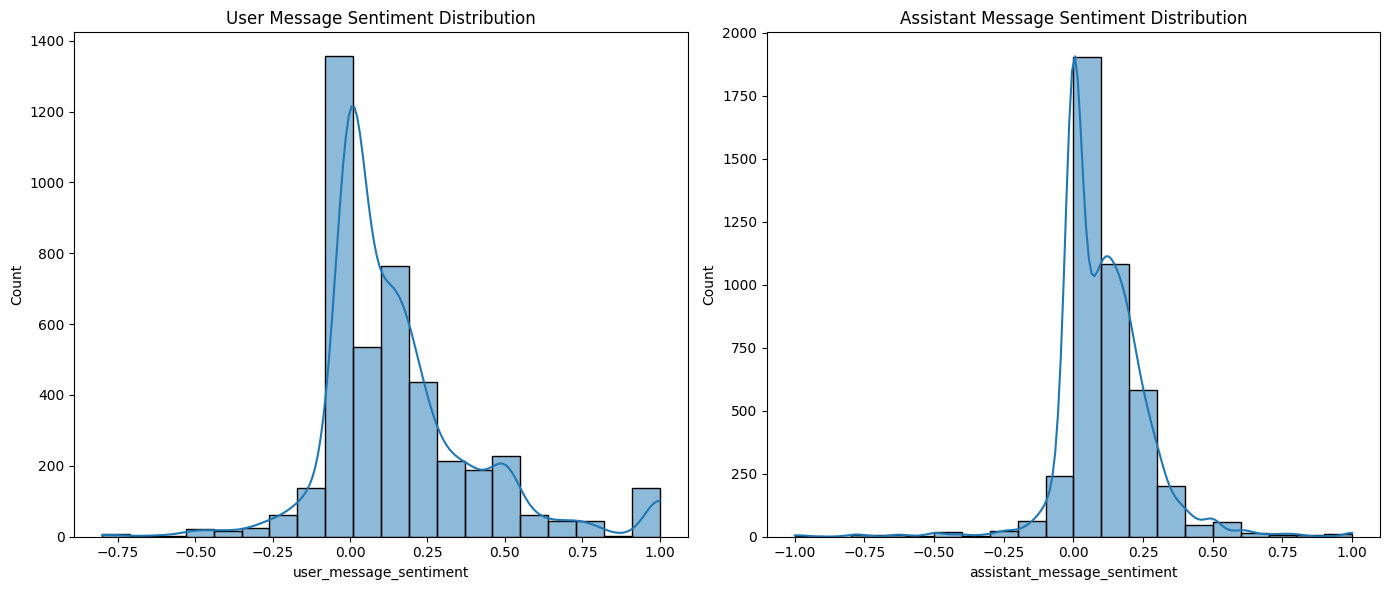

In [13]:
# Importing libraries for visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Sentiment distribution for user and assistant messages
plt.figure(figsize=(14,6))

# User sentiment distribution
plt.subplot(1,2,1)
sns.histplot(data=conversations_df, x='user_message_sentiment', kde=True, bins=20)
plt.title('User Message Sentiment Distribution')

# Assistant sentiment distribution
plt.subplot(1,2,2)
sns.histplot(data=conversations_df, x='assistant_message_sentiment', kde=True, bins=20)
plt.title('Assistant Message Sentiment Distribution')

plt.tight_layout()
plt.show()


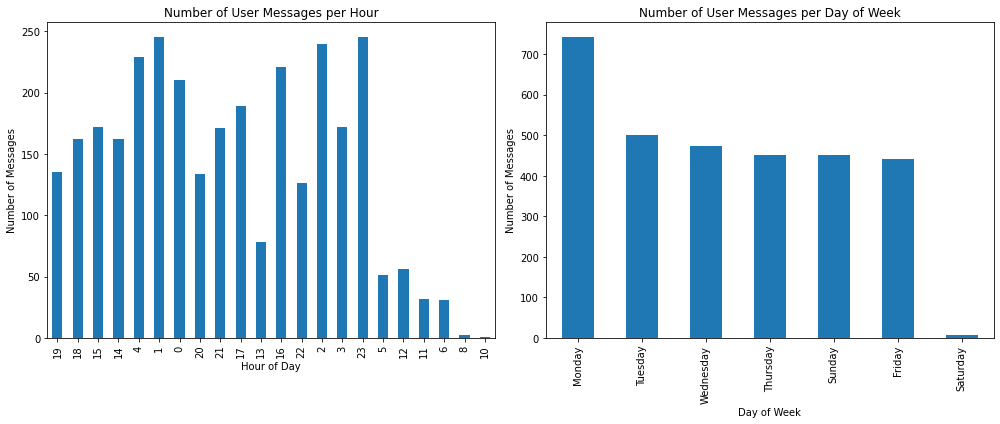

In [ ]:
# Busiest hours of the day and busiest days of the week

plt.figure(figsize=(14,6))

# Busiest hours
plt.subplot(1,2,1)
conversations_df['user_message_hour'].value_counts(sort=False).plot(kind='bar')
plt.title('Number of User Messages per Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Messages')

# Busiest days
plt.subplot(1,2,2)
conversations_df['user_message_day'].value_counts().plot(kind='bar')
plt.title('Number of User Messages per Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Messages')

plt.tight_layout()
plt.show()


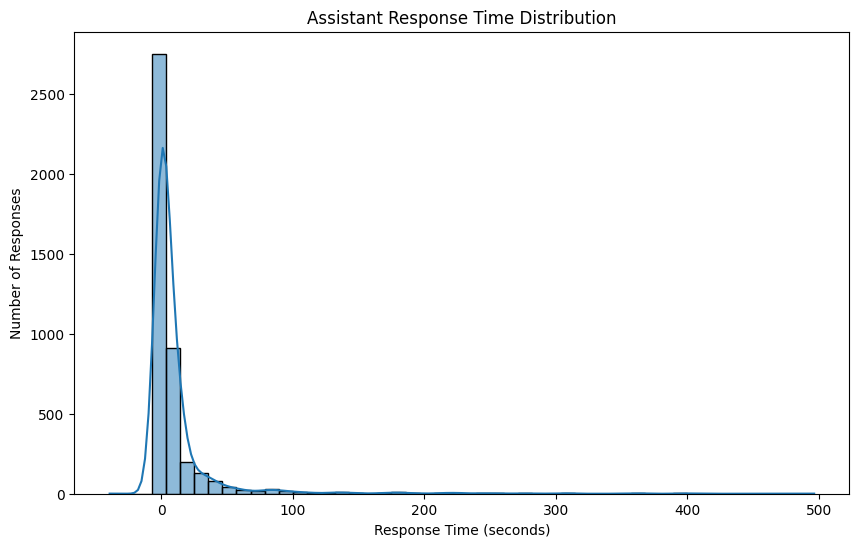

In [14]:
# Response time distribution
plt.figure(figsize=(10,6))
sns.histplot(data=conversations_df, x='response_time', bins=50, kde=True)
plt.title('Assistant Response Time Distribution')
plt.xlabel('Response Time (seconds)')
plt.ylabel('Number of Responses')
plt.show()


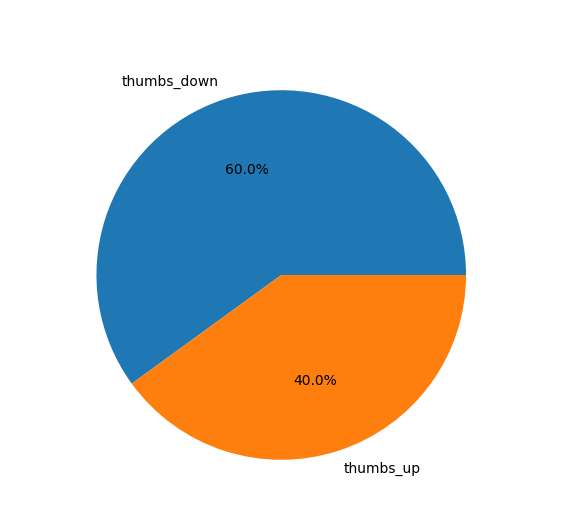

In [15]:
# Feedback ratings distribution
plt.figure(figsize=(6,6))
feedback_df['rating'].value_counts().plot(kind='pie', autopct='%1.1f%%')
# add white background color to the pie chart
plt.style.use('dark_background')
plt.rcParams['text.color'] = 'green'
plt.rcParams['font.size'] = 20
plt.rcParams['font.weight'] = 1000
plt.title('Distribution of Feedback Ratings', color='white')
# add white color to graph title

plt.ylabel('')  # Hide the y-axis label as it's not necessary for a pie chart
plt.show()
